# GP-SDE Model

The notebook is related to Figure 3 in the paper showcasing the effect of different GP priors in an GP-SDE. The kernels used are:

* RBF
* Curl-free
* Divergence-free 

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append("..")

from src.utility import get_observations
from src.gp.model import LatentGPR

In [2]:
def get_trajectory_euler(
    initial_state, v_model, n_trajectories=100, end_state_t=50, dt=1.0
):
    previous_state = np.repeat(
        np.array(initial_state, dtype=np.float64).reshape((1, 2)),
        n_trajectories,
        axis=0,
    )

    all_paths = previous_state
    all_paths = all_paths.reshape((-1, 1, 2))

    n_states = int(end_state_t / dt)

    mvn = np.random.multivariate_normal
    for s in range(1, n_states):
        pred_m, pred_S = v_model.predict_mean_var(previous_state)
        pred_m = pred_m.reshape(previous_state.shape)
        
        x_pred_m = pred_m[:, 0]
        y_pred_m = pred_m[:, 1]
        x_pred_S = pred_S[:, 0]
        y_pred_S = pred_S[:, 1]

        x_pred_covar = np.diag(x_pred_S.reshape(-1))
        y_pred_covar = np.diag(y_pred_S.reshape(-1))

        x_pred = mvn(x_pred_m.reshape(-1), x_pred_covar, 1).reshape(n_trajectories)
        y_pred = mvn(y_pred_m.reshape(-1), y_pred_covar, 1).reshape(n_trajectories)

        previous_state = previous_state + dt * np.stack(
            (x_pred, y_pred), axis=1
        ).reshape(-1, 2)
    
        all_paths = np.hstack((all_paths, previous_state.reshape((-1, 1, 2))))

    return all_paths

## Observations

In [3]:
x_cr, y_cr, u_cr, v_cr = get_observations("circle", 9)

circle_pnts = np.concatenate((x_cr.reshape((-1,1)), y_cr.reshape((-1, 1))), axis=1)

y_labels = np.concatenate((u_cr.reshape((-1,1)), v_cr.reshape((-1,1))), axis=1)
data = (circle_pnts, y_labels)

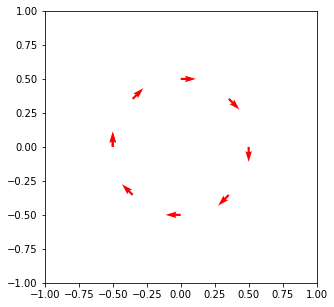

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))
axs.set_aspect("equal", adjustable="box")

plt.quiver(x_cr, y_cr, u_cr, v_cr, color="red", width=0.008)

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.show()

# Gaussian process

In [5]:
k_lengthscale = 0.2
k_variance = 0.1

In [6]:
initial_state = [-0.6, 0.0]
end_t = 15
dt = 0.01
n_trajectories = 10

In [7]:
x = np.linspace(-1, 1, 20)
y = np.linspace(-1, 1, 20)
xx, yy = np.meshgrid(x, y)
zz = np.hstack((xx.reshape(-1, 1), yy.reshape(-1, 1)))

# RBF Kernel

In [8]:
rbf_model = LatentGPR(data, kernel_type="RBF", k_lengthscale=k_lengthscale, k_variance=k_variance)

Model won't be saved as no output path is provided


In [9]:
rbf_pred_m, _ = rbf_model.predict_mean_var(zz)
rbf_pred_m = rbf_pred_m.reshape(zz.shape)

rbf_x_pred_m = rbf_pred_m[:, 0].reshape((20, 20))
rbf_y_pred_m = rbf_pred_m[:, 1].reshape((20, 20))

In [10]:
rbf_predicted_trajectories = get_trajectory_euler(
        initial_state, rbf_model, n_trajectories=n_trajectories, end_state_t=end_t, dt=dt
    )

# Curl-Free kernel

In [11]:
cf_model = LatentGPR(data, kernel_type="curlfree", k_lengthscale=k_lengthscale, k_variance=k_variance)

Model won't be saved as no output path is provided


In [12]:
cf_pred_m, _ = cf_model.predict_mean_var(zz)
cf_pred_m = cf_pred_m.reshape(zz.shape)

cf_x_pred_m = cf_pred_m[:, 0].reshape((20, 20))
cf_y_pred_m = cf_pred_m[:, 1].reshape((20, 20))

In [13]:
cf_predicted_trajectories = get_trajectory_euler(
        initial_state, cf_model, n_trajectories=n_trajectories, end_state_t=end_t, dt=dt
    )

# Divergence-Free kernel

In [14]:
df_model = LatentGPR(data, kernel_type="divergencefree", k_lengthscale=k_lengthscale, k_variance=k_variance)

Model won't be saved as no output path is provided


In [15]:
df_pred_m, _ = df_model.predict_mean_var(zz)
df_pred_m = df_pred_m.reshape(zz.shape)

df_x_pred_m = df_pred_m[:, 0].reshape((20, 20))
df_y_pred_m = df_pred_m[:, 1].reshape((20, 20))

In [16]:
df_predicted_trajectories = get_trajectory_euler(
        initial_state, df_model, n_trajectories=n_trajectories, end_state_t=end_t, dt=dt
    )

## Plotting

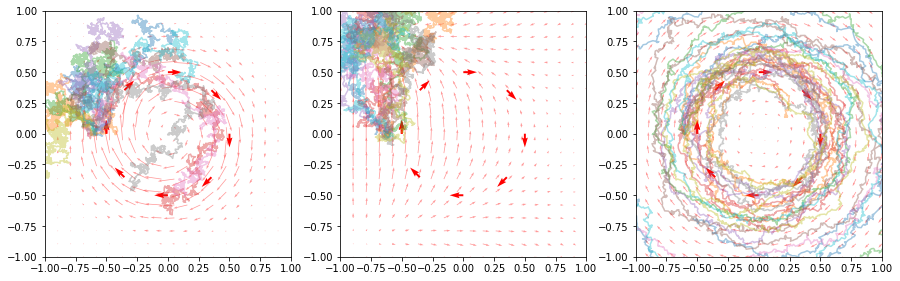

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15, 15))
axs[0].set_aspect("equal", adjustable="box")
axs[1].set_aspect("equal", adjustable="box")
axs[2].set_aspect("equal", adjustable="box")

for t in range(n_trajectories):
    rbf_x_trj = rbf_predicted_trajectories[t, :, 0].reshape(-1)
    rbf_y_trj = rbf_predicted_trajectories[t, :, 1].reshape(-1)
    axs[0].plot(rbf_x_trj, rbf_y_trj, alpha=0.4)

    cf_x_trj = cf_predicted_trajectories[t, :, 0].reshape(-1)
    cf_y_trj = cf_predicted_trajectories[t, :, 1].reshape(-1)
    axs[1].plot(cf_x_trj, cf_y_trj, alpha=0.4)
    
    df_x_trj = df_predicted_trajectories[t, :, 0].reshape(-1)
    df_y_trj = df_predicted_trajectories[t, :, 1].reshape(-1)
    axs[2].plot(df_x_trj, df_y_trj, alpha=0.4)

axs[0].quiver(x_cr, y_cr, u_cr, v_cr, color="red", width=0.008)
axs[1].quiver(x_cr, y_cr, u_cr, v_cr, color="red", width=0.008)
axs[2].quiver(x_cr, y_cr, u_cr, v_cr, color="red", width=0.008)

axs[0].quiver(x, y, rbf_x_pred_m, rbf_y_pred_m, color="red", alpha=0.4)
axs[1].quiver(x, y, cf_x_pred_m, cf_y_pred_m, color="red", alpha=0.4)
axs[2].quiver(x, y, df_x_pred_m, df_y_pred_m, color="red", alpha=0.4)

axs[0].set_xlim(-1, 1)
axs[0].set_ylim(-1, 1)
axs[1].set_xlim(-1, 1)
axs[1].set_ylim(-1, 1)
axs[2].set_xlim(-1, 1)
axs[2].set_ylim(-1, 1)

plt.show()